# **SUPERSTORE SALES ANALYSIS**
___
by: Fadhiil Dzaki Mulyana

# Library

In [89]:
# data manipulation
import pandas as pd
import numpy as np

# data viz
from matplotlib import pyplot as plt, dates as mdates
import seaborn as sns

# map
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import branca.colormap as cm

In [90]:
# overview
def check_overview(df):
    '''
    df_overview adalah fungsi yang digunakan untuk melihat informasi seputar dataset.

    Argumen:
    df = dataset yang digunakan.

    Output:
    Informasi overall dataset, missing value, duplicated value dan jumlah unique value setiap kolom.
    '''
    # df overview
    print(df.info())

    # cek missing value
    print(f"\nmissing values: {round(((df.isna().sum().sum())/len(df))*100, 2)}% \n{df.isna().sum()[df.isna().sum()>0]}")

    # cek duplicated value
    print(f"\nduplicated values: {round(((df.duplicated().sum())/len(df))*100,2)}% \n{df.duplicated().sum()}\n")

    # cek nama kolom & jumlah unique value
    for col in df:
        print(f'{col}-#nunique: {df[col].nunique()}')

# fungsi cek deskriptif stats
def check_deskriptif(df, kolom):
    '''
    Fungsi ini digunakan untuk mengetahui statistik deskriptif.

    Argumen:
    - df = DataFrame
    - kolom = List dari kolom numerik

    Return:
    - DataFrame yang berisi deskriptif statistik data.
    '''
    # deskriptif stats
    deskriptif = df[kolom].describe().T

    # desc stats
    deskriptif = df[kolom].describe().T

    # empty list to store kolom's sums
    sums = []

    # loop calculate sum of feature
    for i in kolom:
        # calculate sum of feature
        total = df[i].sum()

        # add sum to empty list
        sums.append(total)

    # create sum column
    deskriptif['sum'] = sums

    # List untuk menyimpan nilai
    skewness_values = []
    jenis_skewness = []

    # Loop untuk menghitung skewness dan kurtosis setiap kolom
    for i in kolom:
        # Menghitung skewness
        skew = df[i].skew()
        skewness_values.append(skew)
        
        # Menentukan jenis skewness
        if -0.5 <= skew <= 0.5:
            jenis_skewness.append('normal')
        else:
            jenis_skewness.append('skewed')

    # Membuat kolom baru dalam deskriptif
    deskriptif['skewness'] = skewness_values
    deskriptif['jenis_skewness'] = jenis_skewness

    return deskriptif

# fungsi cek outlier
def check_outlier(df, kolom):
    '''
    argumen:
    df = dataframe
    kolom = kolom numerik [list]
    multiplier = pengkali dalam metode IQR (1.5 / 3)
    '''
    # mengecek deskriptif stats
    deskriptif = check_deskriptif(df,kolom)

    # batas atas
    upper_fence = []
    #batas bawah
    lower_fence = []
    # persentase outlier
    percent_outlier = []

    # looping untuk mengisi list kosong
    for i in kolom:
        # bentuk distribusi
        bentuk_dist = deskriptif['jenis_skewness'][i]
        # besar skewness
        besar_skew = deskriptif['skewness'][i]

        # jika bentuk distribusi skew
        if bentuk_dist == 'skewed':
            # jika outlier kecil
            if -1 < besar_skew < 1:
                # mencari Q1,Q2 dan IQR
                Q3 = df[i].quantile(0.75)
                Q1 = df[i].quantile(0.25)
                IQR = Q3-Q1
                
                # menghitung boundaries
                batas_bawah = Q1-1.5*IQR
                batas_atas = Q3+1.5*IQR
            # jika outlier extreeme
            else:
                # mencari Q1,Q2 dan IQR
                Q3 = df[i].quantile(0.75)
                Q1 = df[i].quantile(0.25)
                IQR = Q3-Q1
                # menghitung boundaries
                batas_bawah = Q1-3*IQR
                batas_atas = Q3+3*IQR

        # jika bentuk distribusi normal
        else:
            # rata2 dan st. deviasi
            avg = df[i].mean()
            std = df[i].std()

            # boundaries
            batas_atas = avg + 3*std
            batas_bawah = avg - 3*std

        # menghitung persentase outlier
        persentase_out = ((len(df[df[i] > batas_atas]) / len(df) * 100) + (len(df[df[i] < batas_bawah]) / len(df) * 100))
        persentase_out = round(persentase_out,2)

        # boundaries adn percentage add
        lower_fence.append(batas_bawah)
        upper_fence.append(batas_atas)
        percent_outlier.append(persentase_out)

    # convert to df
    outlier = pd.DataFrame({
        'batas_atas': upper_fence,
        'batas_bawah': lower_fence,
        'persentase' : percent_outlier},
        index=kolom
        )
    # mengembalikan outlier
    return outlier

# Introduction

## Dataset Information
The Superstore Dataset offers a comprehensive platform to delve into the dynamics of sales operations, customer interactions, and the factors that drive business success. It contains information from diverse regions and segments, enabling the exploration of trends, patterns, and correlations in sales and customer preferences. The dataset is specific to the United States and covers a time span from 2014 to 2017.

Column |Descriptions 
-------|-------------
Row ID | Unique ID for each row.
Order ID | Unique Order ID for each Customer.
Order Date | Order Date of the product.
Ship Date | Shipping Date of the Product.
Ship Mode| Shipping Mode specified by the Customer.
Customer ID | Unique ID to identify each Customer.
Customer Name | Name of the Customer.
Segment | The segment where the Customer belongs.
Country | Country of residence of the Customer.
City | City of residence of of the Customer.
State | State of residence of the Customer.
Postal Code | Postal Code of every Customer.
Region | Region where the Customer belong.
Product ID | Unique ID of the Product.
Category | Category of the product ordered.
Sub-Category | Sub-Category of the product ordered.
Product Name | Name of the Product
Sales | Sales of the Product.
Quantity | Quantity of the Product.
Discount | Discount provided.
Profit | Profit/Loss incurred.

## Background
Superstore is a retail company based in the United States specialize in selling furniture, office supplies, and technology products. As a Data Analyst, they asked me to identify weaknesses and opportunities within their business to enhance their business growth and profitability.

## Problem Statement
Enhancing Superstore profit margin up to 15% by identifying weaknesses and opportunities in sales performance, customer segmentation, shipping logistics, etc. By leveraging the Superstore dataset from 2014 to 2017 and collaborating with internal teams, the company will implement actionable improvements within a 12-month timeframe, with quarterly progress reviews to ensure timely adjustments and refinements.

## Problem Breakdown
1. What are the KPIs?
2. Are there noticeable trends or seasonal variations in sales and customer preferences?
3. How effective are the current discount strategies? Do they lead to an increase in sales volume and profitability?
4. Are there specific products, categories, or regions that are underperforming or overperforming?
5. Which states and cities are generating the highest revenue?
5. Which customer segment is bringing in the most profit?
6. What is the most preferred shipping mode among our customers?
7. How effective are the current discount strategies? Do they lead to an increase in sales volume and profitability?

# Data Loading

In [91]:
# load data
df = pd.read_csv("sample_-_superstore(orders).csv", encoding='latin1')

# display all column
pd.set_option('display.max_columns',None)

# change column name to snake case
df.columns = df.columns.str.lower().str.replace('[ -]', '_', regex=True)

# show data
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [92]:
# overall check
check_overview(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_id         9994 non-null   int64  
 1   order_id       9994 non-null   object 
 2   order_date     9994 non-null   object 
 3   ship_date      9994 non-null   object 
 4   ship_mode      9994 non-null   object 
 5   customer_id    9994 non-null   object 
 6   customer_name  9994 non-null   object 
 7   segment        9994 non-null   object 
 8   country        9994 non-null   object 
 9   city           9994 non-null   object 
 10  state          9994 non-null   object 
 11  postal_code    9994 non-null   int64  
 12  region         9994 non-null   object 
 13  product_id     9994 non-null   object 
 14  category       9994 non-null   object 
 15  sub_category   9994 non-null   object 
 16  product_name   9994 non-null   object 
 17  sales          9994 non-null   float64
 18  quantity

**Dataset:**   
The dataset contains 9994 rows and 21 columns:
- Categorical columns: 'row_id', 'order_id', 'ship_mode', 'customer_id', 'customer_name', 'segment', 'country', 'city', 'state', 'postal_code', 'region', 'product_id', 'category', 'sub-category', 'product_name'
- Numerical columns: 'sales', 'quantity', 'discount', 'profit'
- Temporal columns: 'order_date, 'ship_date'

Several columns seems to have wrong data type:
- temporal columns data type must be datetime and must be changed to provide high quality dataset.

**Missing & Duplicated Values:**   
There is no missing or duplicated value.

**Cardinality:**
- it's normal for id columns to have so many unique value since they are an unique identifier.
- 'country' only has 1 unique value, USA, and not provide any valuable information.

# Data Cleaning & Preparation

## Outlier Check

In [93]:
# numeric features
num = ['sales', 'quantity', 'discount', 'profit']

check_outlier(df,num)

,batas_atas,batas_bawah,persentase
sales,787.92000,-560.700,6.68
quantity,14.00000,-7.000,0.00
discount,0.80000,-0.600,0.00
profit,112.26975,-81.177,11.69


## Data Type Manipulation

### Temporal Data to datetime

In [94]:
# define wrong dtype column
wrong_dtype = ['order_date', 'ship_date']

# loop for changing data type
for i in wrong_dtype:
    # change wit    h format mm/dd/yyyy
    df[i] = pd.to_datetime(df[i], format='%m/%d/%Y')

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row_id         9994 non-null   int64         
 1   order_id       9994 non-null   object        
 2   order_date     9994 non-null   datetime64[ns]
 3   ship_date      9994 non-null   datetime64[ns]
 4   ship_mode      9994 non-null   object        
 5   customer_id    9994 non-null   object        
 6   customer_name  9994 non-null   object        
 7   segment        9994 non-null   object        
 8   country        9994 non-null   object        
 9   city           9994 non-null   object        
 10  state          9994 non-null   object        
 11  postal_code    9994 non-null   int64         
 12  region         9994 non-null   object        
 13  product_id     9994 non-null   object        
 14  category       9994 non-null   object        
 15  sub_category   9994 n

In [95]:
# save
df_dtype = df.copy()

In [96]:
# load
df = df_dtype.copy()

## Feature Creation

### Profit Margin
Profit Margin = (Profit/Sales)*100

In [97]:
# create profit margin
df['profit_margin'] = (df['profit']/df['sales'])*100

# check
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,profit_margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,16.00
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,30.00
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,47.00
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,-40.00
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,11.25


In [98]:
# save
df_pmargin = df.copy()

In [99]:
# load
df = df_pmargin.copy()

### Shipping Time
shipping_time = ship date - order date

In [100]:
# create column shipping time
df['shipping_time'] = df['ship_date'] - df['order_date']

# check_d
df[['shipping_time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   shipping_time  9994 non-null   timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 78.2 KB


## Feature Selection

In [101]:
# drop Country
df.drop(columns='country', inplace=True)

# check
check_overview(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   row_id         9994 non-null   int64          
 1   order_id       9994 non-null   object         
 2   order_date     9994 non-null   datetime64[ns] 
 3   ship_date      9994 non-null   datetime64[ns] 
 4   ship_mode      9994 non-null   object         
 5   customer_id    9994 non-null   object         
 6   customer_name  9994 non-null   object         
 7   segment        9994 non-null   object         
 8   city           9994 non-null   object         
 9   state          9994 non-null   object         
 10  postal_code    9994 non-null   int64          
 11  region         9994 non-null   object         
 12  product_id     9994 non-null   object         
 13  category       9994 non-null   object         
 14  sub_category   9994 non-null   object         
 15  prod

# Exploratory Data Analysis

## KPI's

In [102]:
# define kpi columns
kpi = ['sales', 'quantity', 'profit', 'profit_margin']

# desc stats
desc_kpi = check_deskriptif(df,kpi)

# show
desc_kpi

,count,mean,std,min,25%,50%,75%,max,sum,skewness,jenis_skewness
sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480,2.297201e+06,12.972752,skewed
quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000,3.787300e+04,1.278545,skewed
profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976,2.863970e+05,7.561432,skewed
profit_margin,9994.0,12.031393,46.675435,-275.000,7.50000,27.0000,36.250,50.000,1.202417e+05,-2.894826,skewed


Over the past 4 years, Superstore has generated 2.3M sales and 286,397K profit from 37,873 sold items. The average profit margin is 12.03%. According to [Flintfox](https://www.flintfox.com/resources/articles/increase-profit-margin-retail/#:~:text=What%20is%20retail%20margin?,market%20competition%2C%20and%20operational%20costs.), a 10-20 percent retail profit margin is considered healthy. However, it is still lower than the company's target of 15%.

## Sales by Geographics

### Sales by Region

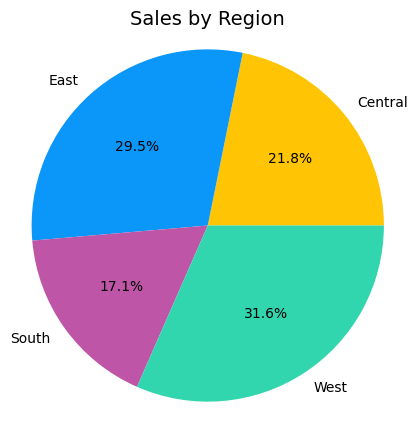

In [171]:
# gruop sales by region
regional_sales = df.groupby('region')['sales'].sum().reset_index()

# create canvas
plt.figure(figsize=(5,5))

# pie chart prep
size = regional_sales['sales']
label = labels=regional_sales['region']
color = ['#FFC505','#0B96F9','#BE55A7','#31D6AE']

# pie chart
plt.pie(size, labels=label ,autopct='%1.1f%%', colors=color)

# set figure equal size
plt.axis('equal')
# add title
plt.title('Sales by Region',fontsize=14)

# show
plt.show()

### Profit by State

In [181]:
# gruop profit & profit by state
state_profit = df.groupby('state')[['sales','profit']].sum().round(2).reset_index()

# Calculate profit margin
state_profit['profit_margin'] = (state_profit['profit']/state_profit['sales']) * 100

# get coordinate
geolocator = Nominatim(user_agent="superstore_analysis")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# add coordinate to data
state_profit['coordinates'] = state_profit['state'].apply(geocode)
state_profit['latitude'] = state_profit['coordinates'].apply(lambda loc: loc.latitude if loc else None)
state_profit['longitude'] = state_profit['coordinates'].apply(lambda loc: loc.longitude if loc else None)

# colormap by profit
max_profit = state_profit['profit'].max()
min_profit = state_profit['profit'].min()
colormap = cm.linear.YlGnBu_09.scale(min_profit, max_profit)

# create map
map_profit = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# add state marker + pop up
for index, row in state_profit.iterrows():
    if not pd.isnull(row['latitude']) and not pd.isnull(row['longitude']):
        folium.CircleMarker(location=(row['latitude'], row['longitude']),
                            radius=8,
                            popup=f"State: {row['state']}<br>Sales: ${row['sales']}<br>Profit: ${row['profit']}",
                            color=colormap(row['profit']),
                            fill=True,
                            fill_color=colormap(row['profit']),
                            fill_opacity=0.7).add_to(map_profit)

# add legend
colormap.add_to(map_profit)

# save map
map_profit.save('profit_map.html')

# show
map_profit

In [178]:
# sort by margin profit
state_profit = state_profit.sort_values(by='profit_margin', ascending=False)

# Top 5 states by profit margin
state_profit[['state','profit_margin']].head()

,state,profit_margin
7,District of Columbia,36.983686
6,Delaware,36.346015
21,Minnesota,36.242627
17,Maine,35.771686
2,Arkansas,34.326472


In [180]:
# bottom 5 states by profit margin
state_profit[['state','profit_margin']].tail()

,state,profit_margin
41,Texas,-15.118194
11,Illinois,-15.727209
40,Tennessee,-17.421279
4,Colorado,-20.330870
33,Ohio,-21.686409


## Sales & Profit by Month

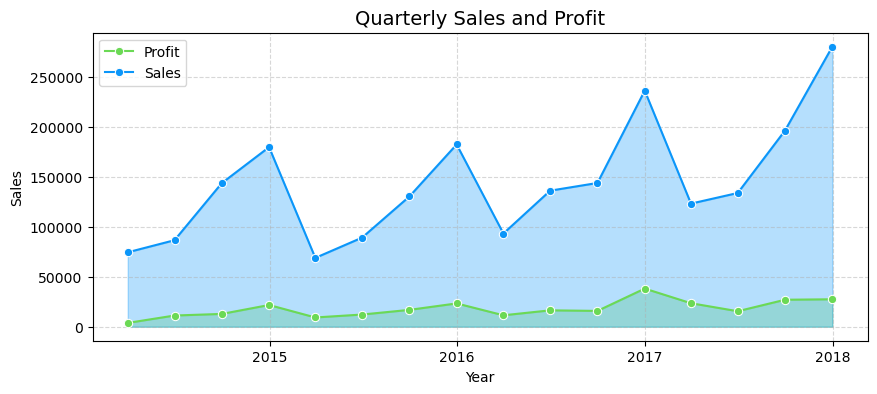

In [105]:
# Calculate daily revenue
daily_revenue = df.groupby('order_date')[['sales', 'profit']].sum().reset_index()

# Sort by order_date and reset index
daily_revenue = daily_revenue.sort_values(by='order_date').reset_index(drop=True)

# Set order_date as index
daily_revenue.set_index('order_date', inplace=True)

# Calculate monthly revenue
quarterly_revenue = daily_revenue.resample('QE').sum()

# create canvas
plt.figure(figsize=(10,4))

# Plot sales and profit
sns.lineplot(x=quarterly_revenue.index, y=quarterly_revenue.profit, label='Profit', marker='o', color='#6BD955')
sns.lineplot(x=quarterly_revenue.index, y=quarterly_revenue.sales, label='Sales', marker='o', color='#0B96F9')

# Fill area under the lines
plt.fill_between(quarterly_revenue.index, quarterly_revenue.profit, color='#6BD955', alpha=0.3)
plt.fill_between(quarterly_revenue.index, quarterly_revenue.sales, color='#0B96F9', alpha=0.3)

# Set major locator and formatter for x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# set x & y label
plt.xlabel('Year')
plt.ylabel('Sales')
# add title
plt.title('Quarterly Sales and Profit', fontsize=14)
# add legend
plt.legend()
# add gridline
plt.grid(linestyle='--', alpha=0.5)

# show plot
plt.show()

**Seasonality**   
Sales in the first quarter of each year always decline, then increase in the following quarters.The yearly highest sales peak occurs in the last quarter of each year, indicating a strong finish to the year. This could be due to holiday season promotions, increased consumer spending, or successful marketing campaigns. However, profits do not show any seasonality.

**Profit Stability**  
The profit figures remain relatively stable and low compared to the sales figures. Despite increasing sales each year, the profit margins are not improving significantly. This indicates that there might be issues with cost management, pricing strategies, or other factors impacting profitability.

## Discount Impact on Sales & Profit

## Sales by Region

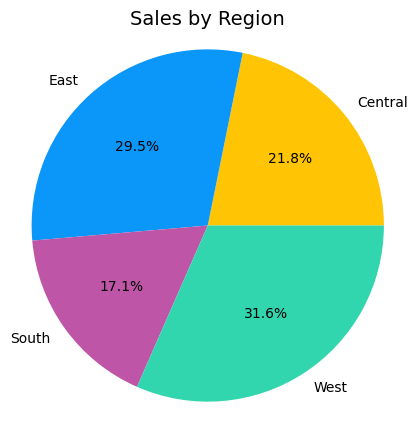

In [106]:
# gruop sales by region
regional_sales = df.groupby('region')['sales'].sum().reset_index()

# create canvas
plt.figure(figsize=(5,5))

# pie chart prep
size = regional_sales['sales']
label = labels=regional_sales['region']
color = ['#FFC505','#0B96F9','#BE55A7','#31D6AE']

# pie chart
plt.pie(size, labels=label ,autopct='%1.1f%%', colors=color)

# set figure equal size
plt.axis('equal')
# add title
plt.title('Sales by Region',fontsize=14)

# show
plt.show()